## Census Block Group to ZCTA crossmapping operation

Certain datasets are captured at highly granular resolution. In those cases, the data may need additional features to ask questions at a broader geographic scale though smaller than State scale.

In this exercise, we will need to create a table that crossmaps between the US Census Block Group ID and geometry with the US Zip Code Tabulation Area (ZCTA) ID and geometry.

The source data will be obtained from these steps:

1) Go to the US Census website: https://www.census.gov/data/data-tools.html

2) Click on the "Explore data" menu, then choose "Data Tools and Apps"

3) Click on "Explore Census Data"; it will take you to https://data.census.gov/cedsci/

4) Search for "ZCTA shapefile

5) In the 'Geographic Products available for ZCTAs' area, click on "TIGER/Line Shapefiles"
    - https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
    
6) Click on "FTP Archive" under the Download section
    - It will take you here: https://www2.census.gov/geo/tiger/TIGER2019/

7) Click on "ZCTA5/"
8) Download and unzip the "tl_2019_us_zcta510.zip"

9) Go back and click on "BG/"
10) Download and unzip the Block group shapefile for your place of interest. The number system corresponds to the State ID.
    - For example, download "tl_2019_72_bg.zip"


In [1]:
import geopandas as gpd
import pandas as pd
import os
%matplotlib inline

In [2]:
import urllib as urllib2
import wget
import bz2
import zipfile
import shutil
import matplotlib.pyplot as plt

In [5]:
# folder prep
if not os.path.exists(os.path.join(os.getcwd(), 'Census_2010_bg_files')):
    os.mkdir(os.path.join(os.getcwd(), 'Census_2010_bg_files'))

In [6]:
def getCensusDataSets(domain='https://www2.census.gov/geo/tiger/TIGER2019/BG',
                      fname='tl_2019_{0}_bg'.format('53'), # default example, Washington state
                      dest_folder=os.path.join(os.getcwd(), 'Census_2010_bg_files')):

    # generate source and local filepath
    filename = fname+'.zip'
    fileurl = os.path.join(domain, filename)
    
    # generate the destination folder
    # replace if it exists
    if os.path.exists(os.path.join(dest_folder, fname)):
        shutil.rmtree(os.path.join(dest_folder, fname))
            
    # download zipfile
    ping = urllib2.request.urlopen(os.path.join(domain, filename))
    if ping.getcode() != 404:
        wget.download(fileurl, out=dest_folder)

    # generate the destination folder
    os.mkdir(os.path.join(dest_folder,fname))

    # extract to destination folder
    with zipfile.ZipFile(os.path.join(dest_folder, filename), 'r') as zip_ref:
        zip_ref.extractall(os.path.join(os.getcwd(),dest_folder, fname))

    # remove zip file
    os.remove(os.path.join(dest_folder, filename))
    return(os.path.join(dest_folder, fname, fname+'.shp'))

In [7]:
#%%time
## get the 5-digit ZCTA shapefile (501 MB file read by wget)

# zcta = getCensusDataSets(domain='https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5',
#                          fname='tl_2019_us_zcta510',
#                          dest_folder=os.path.join(os.getcwd(), 'Census_2010_zcta5_files'))

In [8]:
%%time
# read in the zcta dataset
zcta = gpd.read_file(os.path.join(os.getcwd(),'../Downloads/tl_2019_us_zcta510/tl_2019_us_zcta510.shp'))

print(zcta.shape)
zcta.head()

(33144, 10)
CPU times: user 18.1 s, sys: 1.73 s, total: 19.8 s
Wall time: 21.5 s


,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.708733 41.327326, -83.708147 41...."
1,43452,43452,B5,G6350,S,121522304,13721730,+41.5157923,-082.9809454,"POLYGON ((-83.086978 41.537796, -83.0825629999..."
2,43456,43456,B5,G6350,S,9320975,1003775,+41.6318300,-082.8393923,"(POLYGON ((-82.835577 41.710823, -82.83515 41...."
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650299999999 41.253708, -83.48..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.222292 41.531025, -83.2222819999..."


In [9]:
def crossmap_BG_to_ZCTA(poly_bg, poly_zcta, outshapefilepath, uid='GEOID',
                        zip_code_fieldname='ZCTA5CE10'):
    
    """
    poly_bg (geodataframe): geodataframe of the Census Block group file
    poly_zcta (geodataframe): geodataframe of the ZCTA polygon file
    outshapefilepath (dir): the output diretory and name for the shapefile; will also be used for the csv output
    uid (str): GEOID or an equivalent to recognize unique shapes
    zip_code_fieldname (str): ZCTA5CE10 or equivalent to recognize ZIP Codes or ZCTA spatial units
    
    return: 1) mappings as a shapefile and 2) mappings as a csv table
    """

    """
    1) identify BGs with geometry that fit within ZCTAs
    """
    poly_bg['centroid'] = poly_bg.centroid
    bg_within = gpd.sjoin(poly_bg.set_geometry('geometry'), poly_zcta, 
                          how='inner', op='within').drop('index_right', axis=1)
    bg_within = bg_within.assign(overlay='geometry within ZCTA')

    print(bg_within.shape)

    """
    2) identify BGs that intersect by polygon centroid
    """
    # extract block groups that could not be joined with within method
    bg2 = poly_bg[~poly_bg['GEOID'].isin(bg_within['GEOID'])]
    bg_intersects = gpd.sjoin(bg2.set_geometry('centroid'), poly_zcta, 
                              how='inner', op='intersects').drop('index_right', axis=1)\
        .assign(overlay='centroid intersects ZCTA')

    print(bg_intersects.shape)

    """
    3) identify BGs that intersect with one zcta by polygon geometry
    """
    # extract block groups that could not be joined with centroid intersection method
    bg3 = bg2.loc[~bg2['GEOID'].isin(bg_intersects['GEOID']),:]
    bg_g_left = gpd.sjoin(bg3.set_geometry('geometry'), poly_zcta, 
                          how='inner', op='intersects').drop('index_right', axis=1)
    mappings = bg_g_left.groupby(uid)[zip_code_fieldname].nunique()
    bg_g_left1 = bg_g_left.loc[bg_g_left['GEOID'].isin(mappings[mappings==1].dropna().index),:]\
        .assign(overlay='geometry intersects a single ZCTA')

    print(bg_g_left1.shape)

    """
    4) identify BGs with multiple ZCTA by geometry intersection, but 0 ZCTA by centroid intersection
    """
    bg4 = bg3.loc[~bg3['GEOID'].isin(bg_g_left1['GEOID']),:]
    bg_c_left = gpd.sjoin(bg4.set_geometry('centroid'), poly_zcta,
                          how='left', op='intersects').drop('index_right', axis=1)
    bg_c_left1 = bg_c_left[bg_c_left['GEOID'].isin(mappings[mappings>1].dropna().index)]\
        .assign(overlay='geometry intersects multiple ZCTA, centroid intersects 0 ZCTA')

    print(bg_c_left1.shape)

    """
    5) merge the spatial joins, report, then export
    """
    bg_mapped = pd.concat([bg_within, bg_intersects, bg_g_left1, bg_c_left1], axis=0)

    # coverage
    print('geometry within: {0} ({1}%)'\
          .format(bg_within.shape[0], round(bg_within.shape[0]/poly_bg.shape[0]*100,5)))
    
    print('centroid intersects: {0} ({1}%)'\
          .format(bg_intersects.shape[0], round(bg_intersects.shape[0]/poly_bg.shape[0]*100, 5)))
    
    print('geometry intersects 1 ZCTA: {0} ({1}%)'\
          .format(bg_g_left1.shape[0], round(bg_g_left1.shape[0]/poly_bg.shape[0]*100, 5)))
    
    print('geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: {0} ({1}%)'\
          .format(bg_c_left1.shape[0], round(bg_c_left1.shape[0]/poly_bg.shape[0]*100, 5)))
    
    print('total coverage: {0}/{1}'\
          .format(bg_mapped[uid].isin(poly_bg[uid]).sum()[0], poly_bg[uid].nunique()[0]))

    # create directory if not exist
    if not os.path.exists(os.path.abspath(os.path.dirname(outshapefilepath))):
        os.mkdir(os.path.abspath(os.path.dirname(outshapefilepath)))

    # export to shapefiles (replace existing shapefile)
    bg_mapped.drop('centroid', axis=1).to_file(outshapefilepath)

    # export to dataframe
    bg_mapped.drop(['geometry','centroid'], axis=1)\
        .to_csv(outshapefilepath.replace('.shp','.csv'), header=True, index=False)
    return(bg_mapped)

In [119]:
def renderMap(gdf, outfilepath, scale_variable, plot_variable):
    
    "examine all census block group plots"
    # create directory if not exist
    if not os.path.exists(os.path.abspath(os.path.dirname(outfilepath))):
        os.mkdir(os.path.abspath(os.path.dirname(outfilepath)))
    
    # add county reference boundaries
    ax=gdf.dissolve(by='COUNTYFP').reset_index()\
        .plot(color=None, ec='black', figsize=(15,15), zorder=10, alpha=0.2)
    
    # plot the overlays
    gdf.plot('overlay', ec=None, alpha=1, zorder=1, legend=True, ax=ax, 
             legend_kwds={'loc': 'lower right', 'ncol':4, 'fontsize':9})

    plt.savefig(outfilepath, dpi=300)

## Do this for the State of Washington

In [132]:
WA_cbg = getCensusDataSets(fname='tl_2019_{0}_bg'.format('53'), # default example, Washington state
                           dest_folder=os.path.join(os.getcwd(), 'Census_2010_bg_files'))

#Washington
bg = gpd.read_file(WA_cbg)

WA_bg_mapped = crossmap_BG_to_ZCTA(poly_bg = bg,
                                   poly_zcta = zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                                   outshapefilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap',
                                                                 'tl_2019_{0}_bg'.format('53'),
                                                                 'tl_2019_{0}_bg.shp'.format('53')),
                                   uid=['GEOID'],
                                   zip_code_fieldname=['ZCTA5CE10'])

WA_bg_mapped.head()

(3217, 17)
(1521, 17)
(14, 17)
(31, 17)
geometry within: 3217 (67.25904%)
centroid intersects: 1521 (31.80013%)
geometry intersects 1 ZCTA: 14 (0.2927%)
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 31 (0.64813%)
total coverage: 4783/4783


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
0,53,029,971400,2,530299714002,Block Group 2,G5030,S,2814636,1797525,+48.2062765,-122.5296535,"POLYGON ((-122.54657 48.208011, -122.542498 48...",POINT (-122.534503746297 48.21329260397864),98282,98282,geometry within ZCTA
1,53,029,971400,3,530299714003,Block Group 3,G5030,S,22645103,62368,+48.2125091,-122.4991207,"POLYGON ((-122.527323 48.182455, -122.527269 4...",POINT (-122.5019259583019 48.21954474215514),98282,98282,geometry within ZCTA
2,53,029,971500,1,530299715001,Block Group 1,G5030,S,14190551,3407670,+48.2523579,-122.4561538,"POLYGON ((-122.485032 48.255073, -122.482159 4...",POINT (-122.4465031900918 48.25285264723762),98282,98282,geometry within ZCTA
3,53,029,971500,2,530299715002,Block Group 2,G5030,S,13421381,9435655,+48.2145613,-122.4526433,"POLYGON ((-122.481784 48.167791, -122.481692 4...",POINT (-122.4491330659283 48.21432247307372),98282,98282,geometry within ZCTA
4,53,029,971600,1,530299716001,Block Group 1,G5030,S,13176547,2594118,+48.1716032,-122.5137524,"POLYGON ((-122.539167 48.190496, -122.544349 4...",POINT (-122.5091104286969 48.1780544999796),98282,98282,geometry within ZCTA


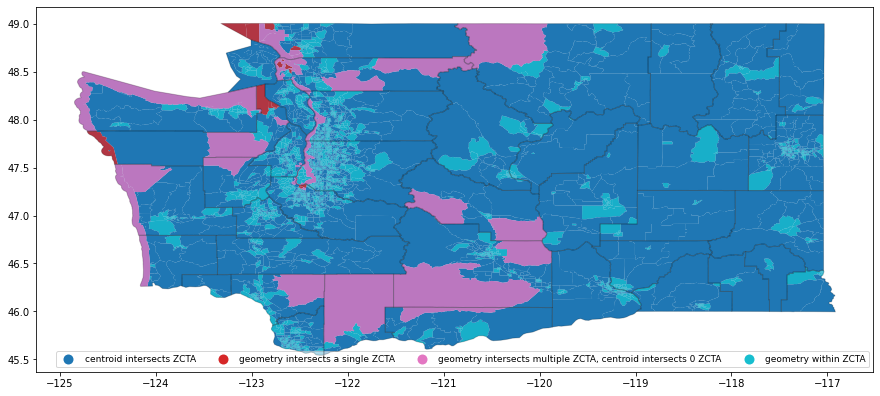

In [118]:
renderMap(gdf=WA_bg_mapped,
          outfilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap',
                                   'tl_2019_{0}_bg'.format('53'),
                                   'tl_2019_{0}_bg.png'.format('53')),
          scale_variable='ZCTA5CE10',
          plot_variable='overlay')

## Do this for the State of Maryland

In [122]:
MD_cbg = getCensusDataSets(fname = 'tl_2019_{0}_bg'.format('24')) #Maryland
bg = gpd.read_file(MD_cbg)

MD_bg_mapped = crossmap_BG_to_ZCTA(poly_bg = bg,
                                   poly_zcta = zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                                   outshapefilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap','MA_cbg.shp'),
                                   uid=['GEOID'],
                                   zip_code_fieldname=['ZCTA5CE10'])

MD_bg_mapped.head()

(2752, 17)
(1145, 17)
(1, 17)
(28, 17)
geometry within: 2752 (70.09679%)
centroid intersects: 1145 (29.16454%)
geometry intersects 1 ZCTA: 1 (0.02547%)
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 28 (0.71319%)
total coverage: 3926/3926


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
0,24,021,766800,1,240217668001,Block Group 1,G5030,S,3716906,29841,+39.7144388,-077.3255060,"POLYGON ((-77.350528 39.719905, -77.34956 39.7...",POINT (-77.32774341088064 39.71445092263749),21727,21727,geometry within ZCTA
35,24,021,766800,2,240217668002,Block Group 2,G5030,S,15538729,205270,+39.6962069,-077.3218443,"POLYGON ((-77.36952099999999 39.719897, -77.36...",POINT (-77.32104128540583 39.69518617085095),21727,21727,geometry within ZCTA
961,24,021,766800,4,240217668004,Block Group 4,G5030,S,3872155,0,+39.7093596,-077.3056646,"POLYGON ((-77.326818 39.704791, -77.326678 39....",POINT (-77.30566417732801 39.70935972932294),21727,21727,geometry within ZCTA
1,24,510,260202,2,245102602022,Block Group 2,G5030,S,386535,0,+39.3213360,-076.5517123,"POLYGON ((-76.5608 39.325908, -76.560712 39.32...",POINT (-76.55428640383786 39.32436043523699),21206,21206,geometry within ZCTA
704,24,510,270102,2,245102701022,Block Group 2,G5030,S,208076,0,+39.3387926,-076.5559230,"POLYGON ((-76.559681 39.339643, -76.55855 39.3...",POINT (-76.55592299967061 39.33879265069555),21206,21206,geometry within ZCTA


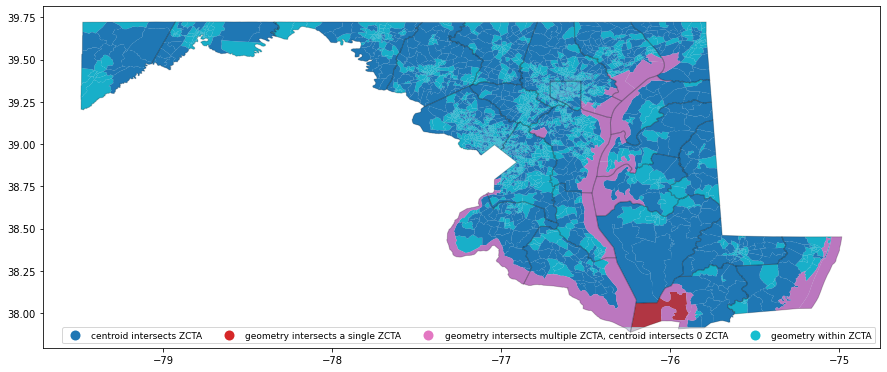

In [125]:
renderMap(gdf=MD_bg_mapped,
          outfilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap',
                                   'tl_2019_{0}_bg'.format('24'),
                                   'tl_2019_{0}_bg.png'.format('24')),
          scale_variable='ZCTA5CE10',
          plot_variable='overlay')

## Do this for the State of New York

In [128]:
NY_cbg = getCensusDataSets(fname = 'tl_2019_{0}_bg'.format('36')) #New York
bg = gpd.read_file(NY_cbg)

NY_bg_mapped = crossmap_BG_to_ZCTA(poly_bg = bg,
                                   poly_zcta = zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                                   outshapefilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap','NY_cbg.shp'),
                                   uid=['GEOID'],
                                   zip_code_fieldname=['ZCTA5CE10'])

NY_bg_mapped.head()

(11082, 17)
(4061, 17)
(89, 17)
(223, 17)
geometry within: 11082 (71.66785%)
centroid intersects: 4061 (26.26269%)
geometry intersects 1 ZCTA: 89 (0.57557%)
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 223 (1.44215%)
total coverage: 15455/15463


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
3,36,081,025900,2,360810259002,Block Group 2,G5030,S,64620,0,+40.7464004,-073.9045386,"POLYGON ((-73.906419 40.745635, -73.905349 40....",POINT (-73.90453859985594 40.74640035719982),11377,11377,geometry within ZCTA
142,36,081,016300,3,360810163003,Block Group 3,G5030,S,99913,0,+40.7563293,-073.9100420,"POLYGON ((-73.912397 40.756236, -73.910684 40....",POINT (-73.91004203912203 40.75632933662267),11377,11377,geometry within ZCTA
144,36,081,020500,2,360810205002,Block Group 2,G5030,S,74057,0,+40.7339998,-073.9196383,"POLYGON ((-73.922248 40.734415, -73.922062 40....",POINT (-73.9196382549877 40.73399982343042),11377,11377,geometry within ZCTA
149,36,081,030902,5,360810309025,Block Group 5,G5030,S,47696,0,+40.7553617,-073.8979006,"POLYGON ((-73.89948 40.75624699999999, -73.898...",POINT (-73.8979005800104 40.75536173121595),11377,11377,geometry within ZCTA
170,36,081,024300,4,360810243004,Block Group 4,G5030,S,131682,0,+40.7387414,-073.8978570,"POLYGON ((-73.899869 40.73844, -73.899829 40.7...",POINT (-73.89785701546383 40.73874143900247),11377,11377,geometry within ZCTA


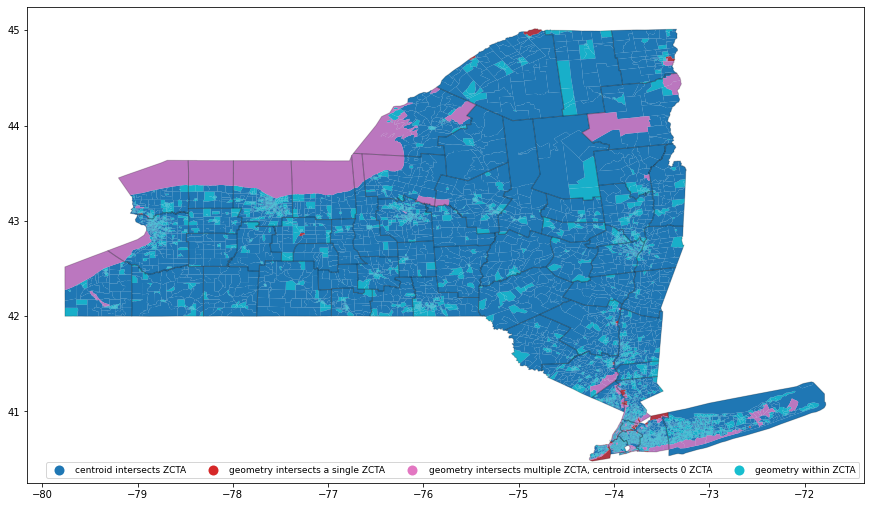

In [129]:
renderMap(gdf=NY_bg_mapped,
          outfilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap',
                                   'tl_2019_{0}_bg'.format('36'),
                                   'tl_2019_{0}_bg.png'.format('36')),
          scale_variable='ZCTA5CE10',
          plot_variable='overlay')

## Do this for the State of California

In [130]:
CA_cbg = getCensusDataSets(fname = 'tl_2019_{0}_bg'.format('06')) #California
bg = gpd.read_file(CA_cbg)

CA_bg_mapped = crossmap_BG_to_ZCTA(poly_bg = bg,
                                   poly_zcta = zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                                   outshapefilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap','CA_cbg.shp'),
                                   uid=['GEOID'],
                                   zip_code_fieldname=['ZCTA5CE10'])

CA_bg_mapped.head()

(18132, 17)
(4876, 17)
(16, 17)
(185, 17)
geometry within: 18132 (78.11477%)
centroid intersects: 4876 (21.00638%)
geometry intersects 1 ZCTA: 16 (0.06893%)
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 185 (0.797%)
total coverage: 23209/23212


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
0,06,053,011101,3,060530111013,Block Group 3,G5030,S,1399858,456,+36.4159450,-121.3164457,"POLYGON ((-121.327436 36.423514, -121.327264 3...",POINT (-121.3187288922656 36.41901799305388),93960,93960,geometry within ZCTA
1,06,053,011102,2,060530111022,Block Group 2,G5030,S,1451663,0,+36.4352108,-121.3300395,"POLYGON ((-121.337434 36.431699, -121.33714 36...",POINT (-121.3300395041561 36.43521117526385),93960,93960,geometry within ZCTA
10548,06,053,011101,2,060530111012,Block Group 2,G5030,S,284426,0,+36.4238452,-121.3129817,"POLYGON ((-121.316209 36.42395399999999, -121....",POINT (-121.3129816662145 36.42384516866525),93960,93960,geometry within ZCTA
10549,06,053,011102,1,060530111021,Block Group 1,G5030,S,1184434,0,+36.4300019,-121.3197869,"POLYGON ((-121.32921 36.430274, -121.328184 36...",POINT (-121.3197869746227 36.43000190810328),93960,93960,geometry within ZCTA
14154,06,053,010900,1,060530109001,Block Group 1,G5030,S,3604357,15260,+36.4743205,-121.3770688,"POLYGON ((-121.391472 36.467038, -121.39119 36...",POINT (-121.3764295249217 36.47178917462824),93960,93960,geometry within ZCTA


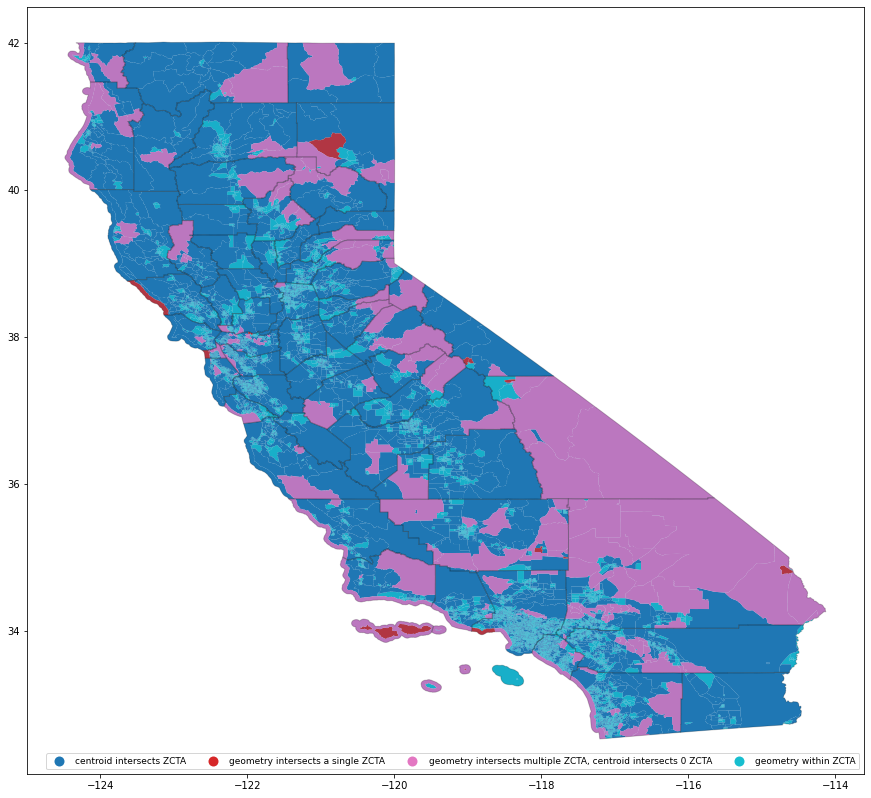

In [131]:
renderMap(gdf=CA_bg_mapped,
          outfilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap',
                                   'tl_2019_{0}_bg'.format('06'),
                                   'tl_2019_{0}_bg.png'.format('06')),
          scale_variable='ZCTA5CE10',
          plot_variable='overlay')

In [ ]:
## remaining states queued for crossmapping

# TN
# TX
# KY
# AK
# NJ
# NH
# CT
# MA
# OR
# IN
# NC
# CA
# UT

In [ ]:
TN_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('47')) #Tennessee
# TX_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('48')) #Texas
# KY_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('21')) #KY
# AK_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('05')) #Arkansas
# NJ_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('34')) #New Jersey
# NH_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('33')) #New Hampshire
# CT_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('09')) #Conneticut
#MA_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('25')) #Massachusetts